In [80]:
! pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re


In [100]:
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
import fasttext
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

### Initial cleaning and language filtering

In [4]:
df = pd.read_csv('../data/ds2.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913411 entries, 0 to 5913410
Data columns (total 8 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   title     object
 1   tag       object
 2   artist    object
 3   year      int64 
 4   views     int64 
 5   features  object
 6   lyrics    object
 7   id        int64 
dtypes: int64(3), object(5)
memory usage: 360.9+ MB


In [6]:
df.head()

,title,tag,artist,year,views,features,lyrics,id
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6


In [7]:
# Drop columns that are not needed
df.drop(columns=['views', 'features'], inplace=True)

In [9]:
# Value counts for each genre
df['tag'].value_counts()


tag
pop        2519256
rap        1962010
rock        892220
rb          225342
misc        208714
country     105869
Name: count, dtype: int64

In [10]:
# drop genre "misc" (miscellaneous) from df
df = df[df.tag != 'misc']

In [15]:
# check if only unique genres are in df
df['tag'].unique()

array(['rap', 'rb', 'rock', 'pop', 'country'], dtype=object)

In [17]:
# show nan values in each column
df.isnull().sum()

title      407
tag          0
artist       0
year         0
lyrics    1011
id           0
dtype: int64

In [27]:
# Show the NAn Values in the title column
df[df['title'].isnull()].head(25)

,title,tag,artist,year,lyrics,id


In [26]:
# drop nan values in columns lyrics, tag, and title
df.dropna(subset=['lyrics', 'tag', 'title'], inplace=True)


In [31]:
df.head()

,title,tag,artist,year,lyrics,id
0,Killa Cam,rap,Cam'ron,2004,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1
1,Can I Live,rap,JAY-Z,1996,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3
2,Forgive Me Father,rap,Fabolous,2003,Maybe cause I'm eatin\nAnd these bastards fien...,4
3,Down and Out,rap,Cam'ron,2004,[Produced by Kanye West and Brian Miller]\n\n[...,5
4,Fly In,rap,Lil Wayne,2005,"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6


In [33]:
#df.to_pickle('../data/df_cleaned_1.pkl')

In [5]:
#df = pd.read_pickle('../data/df_cleaned_1.pkl')

In [13]:
# Load FastText's language identification model
model = fasttext.load_model('../fasttext/lid.176.bin')

# Detect language function
def detect_language(text):
    text = text.replace('\n', ' ')  # Replace newline characters with spaces
    predictions = model.predict(text, k=1)  # k is the number of language predictions to return
    lang = predictions[0][0].replace('__label__','')  # Get the language code
    return lang

In [16]:
# Detect language for each row in lyrics column
tqdm.pandas(desc="Detecting language")
df['language'] = df['lyrics'].progress_apply(detect_language)

Detecting language: 100%|██████████| 5703331/5703331 [08:17<00:00, 11472.93it/s]


In [17]:
df.head()

,title,tag,artist,year,lyrics,id,language
0,Killa Cam,rap,Cam'ron,2004,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en
1,Can I Live,rap,JAY-Z,1996,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en
2,Forgive Me Father,rap,Fabolous,2003,Maybe cause I'm eatin\nAnd these bastards fien...,4,en
3,Down and Out,rap,Cam'ron,2004,[Produced by Kanye West and Brian Miller]\n\n[...,5,en
4,Fly In,rap,Lil Wayne,2005,"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en


In [19]:
# keep only english songs
df = df[df['language'] == 'en']

In [24]:
# Save df to pickle
#df.to_pickle('../data/df_cleaned_engl.pkl')

### EDA

In [104]:
# Read cleaned and filtered df from pickle
df = pd.read_pickle('/work/cleaned_df/df_cleaned_engl.pkl')

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4042601 entries, 0 to 5913410
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   title     object
 1   tag       object
 2   artist    object
 3   year      int64 
 4   lyrics    object
 5   id        int64 
 6   language  object
dtypes: int64(2), object(5)
memory usage: 246.7+ MB


We did a first initial cleaning and filtered out all non-english songs, songs with the tag 'misc', and rows with NaN values. Now, the df contains more 4042601 english songs with the features title, tag, artist, year, lyrics and id.

In [106]:
# Rename the column tag to genre 
df.rename(columns={"tag": "genre"}, inplace=True)

In [107]:
genre_counts = df['genre'].value_counts()
genre_counts

genre
pop        1818130
rap        1207176
rock        737168
rb          187550
country      92577
Name: count, dtype: int64

In [108]:
genre_counts.describe()

count    5.000000e+00
mean     8.085202e+05
std      7.213716e+05
min      9.257700e+04
25%      1.875500e+05
50%      7.371680e+05
75%      1.207176e+06
max      1.818130e+06
Name: count, dtype: float64

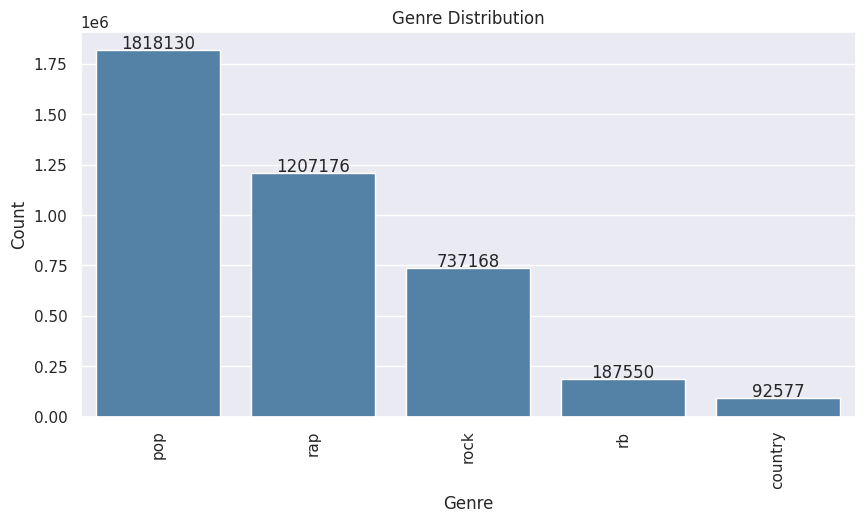

In [109]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, x='genre', order=df['genre'].value_counts().index, color='steelblue')
# Add count labels to the columns
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.xticks(rotation=90)
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()


The distribution of the genre labels in the dataset is very imbalanced. There are only 92577 country songs while there are over 1.8 million pop songs. 

In [110]:
year_counts = df['year'].value_counts()
year_counts

year
2020    460151
2021    418109
2019    396736
2015    350990
2018    336073
         ...  
514          1
1748         1
1633         1
1783         1
1431         1
Name: count, Length: 485, dtype: int64

Most of the songs are from recent years whereas some songs are very old. Since the songs seem really old and the years are a bit odd, we will examine the years with low song counts closer.

In [111]:
odd_years = year_counts[year_counts == 2].index
filtered_df = df[df['year'].isin(odd_years)]
filtered_df

,title,genre,artist,year,lyrics,id,language
145757,The History of Tom Jones a Foundling Chap. 8.7,rap,Henry Fielding,1749,Containing better reasons than any which have ...,155315,en
145762,The History of Tom Jones a Foundling Chap. 8.9,rap,Henry Fielding,1749,Containing several dialogues between Jones and...,155320,en
208036,Advice to a Friend on Choosing a Mistress,rap,Benjamin Franklin,1745,"June 25, 1745\n\nMy dear Friend\n\nI know of n...",223606,en
216527,Put a Little Umph In It,rb,Jagged Edge,207,"[Intro: Jermaine Dupri, Ashtani, Kyle & Jagged...",235635,en
250149,FDB Fuck Dat Bitch G-Mix,rap,Young Dro,1415,"West Side, Bankhead, is where I'm from\nEveryt...",327414,en
...,...,...,...,...,...,...,...
5238604,Mityu pchelatuh,rock,HARMAN TAARSH,205,Kiro cuh e bati pederasa\nToi e ot romskata ra...,7022057,en
5553257,I shit fart pee pee,rap,A$AP Rocky,1686,I bee shitting... farting. IM BROWNING\n\n\nIM...,7418234,en
5566508,Play Me Like That Video Game,pop,Josef Bel Habib,994,Play Me Like That Video Game (Time to Level at...,7434368,en
5738079,GYM,rap,Tommy Stoner,499,[Instrumental],7654006,en


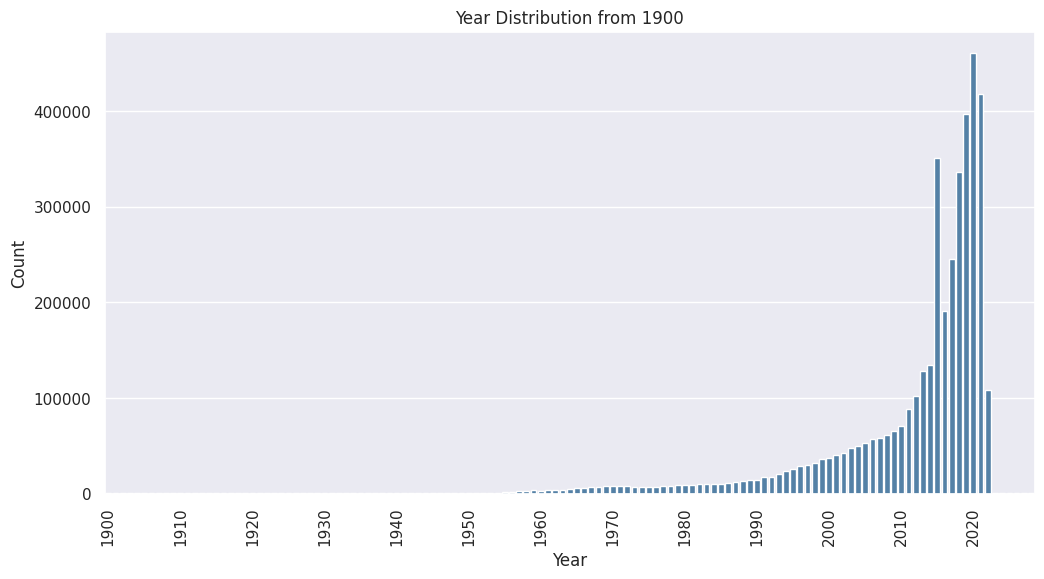

In [112]:
year_counts = df['year'].value_counts()
valid_years = year_counts.index

year_order = df['year'].sort_values().unique()
valid_years = valid_years[valid_years >= 1900]

valid_years = sorted(valid_years)  # Sort the valid years in ascending order


sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df[df['year'].isin(valid_years)], x='year', order=valid_years, color='steelblue')

# Display only every 10th year on the x-axis
every_10th_year = [year if i % 10 == 0 else '' for i, year in enumerate(valid_years)]
ax.set_xticklabels(every_10th_year)
plt.xticks(rotation=90)

plt.title('Year Distribution from 1900')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

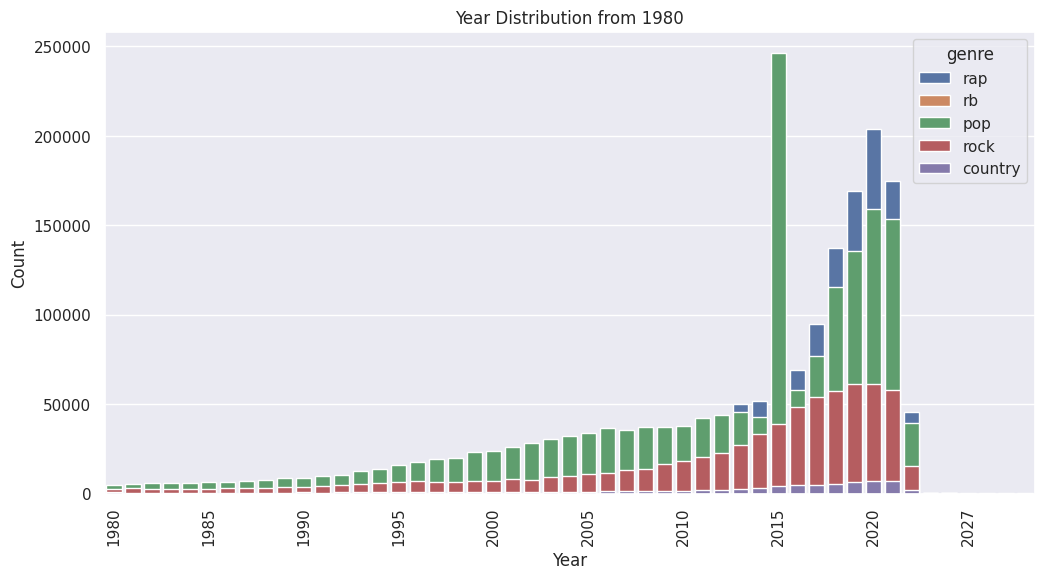

In [113]:
year_counts = df['year'].value_counts()
valid_years = year_counts.index

year_order = df['year'].sort_values().unique()
valid_years = valid_years[valid_years >= 1980]

valid_years = sorted(valid_years)  # Sort the valid years in ascending order


sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df[df['year'].isin(valid_years)], x='year', order=valid_years, hue='genre', dodge=False)

# Display only every 10th year on the x-axis
every_10th_year = [year if i % 5 == 0 else '' for i, year in enumerate(valid_years)]
ax.set_xticklabels(every_10th_year)
plt.xticks(rotation=90)

plt.title('Year Distribution from 1980')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

The genres rap and country evolved later and since the last 10-20 years. Before the 2000s rock and pop were only present in this data. The year 2015 

In [114]:
# Examining word_count
df['word_count'] = df['lyrics'].apply(lambda x: len(x.split()))


In [115]:
df['word_count'].value_counts().describe()

count      3314.000000
mean       1219.855462
std       11131.703028
min           1.000000
25%           1.000000
50%           4.000000
75%         297.500000
max      626826.000000
Name: count, dtype: float64

The word_count in lyrics has a wide range from 1 to 600000. We will filter the df for rows with a minimum of 50 words in lyrics and max of 10000 words.

In [116]:
df = df[(df['word_count'] < 5000) & (df['word_count'] > 50)]

<Axes: xlabel='word_count', ylabel='Count'>

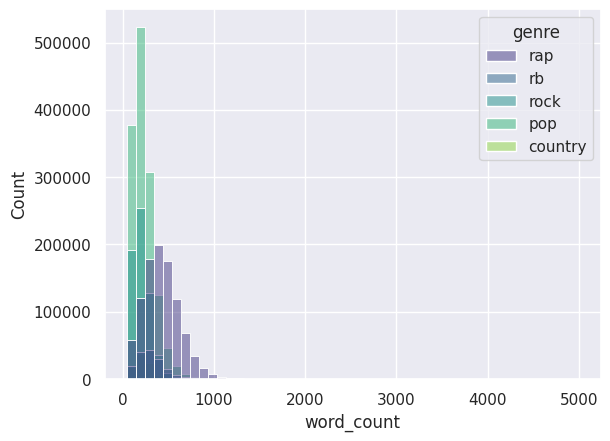

In [117]:
sns.histplot(data=df, x='word_count', bins=50, hue='genre', palette='viridis')

The histplot above shows that rap songs contain usually more words than the other genres. 

### Text Preprocessing

In [118]:
df.loc[100,'lyrics']

'[Produced by The Neptunes]\n\n[Intro: JAY-Z, Pharrell]\nYoung! It\'s the life\nOnce again it\'s the life, yes\nI don\'t know why, I.. get so high oh\nIt\'s intoxicating, man, y\'all don\'t know why you do what you do\nGet so high oh, get so high, high off the life\n\n[Verse 1: JAY-Z]\nThe allure of breaking the law\nWas always too much for me to ever ignore\nI\'ve got a thing for the big-body Benzes, it dulls my senses\nIn love with a V-Dub engine\nMan, I\'m high off life, fuck it, I\'m wasted\nBathing Ape kicks, Audemars Piguet wrist\nMy women-friends get tennis bracelets\nTrips to Venice, get their Winters replaced with\nThe sun...it ain\'t even fun no more, I\'m jaded\nMan, it\'s just a game, I just play it to play it\nI put my feet in the footprints left to me\nWithout saying a word, the ghetto\'s got a mental telepathy\nMan, my brother hustled so, naturally\nUp next was me, but what perplexes me\nShit, I know how this movie ends, still I play\nThe starring role in "Hovito\'s Way"

We want to remove everything in '[]' and also get rid of everything starting with '\' (for example: \n)

In [123]:
def strip_lyrics(lyrics):
    # Remove strings enclosed in brackets []
    lyrics = re.sub(r'\[.*?\]', '', lyrics)
    
    # Remove substrings starting with a backslash \
    lyrics = re.sub(r'\\[^\s]*', '', lyrics)

    # Remove newline characters \n
    lyrics = re.sub(r'\n', ' ', lyrics)
    
    # Remove single quotes '
    lyrics = re.sub(r"'", '', lyrics)
    
    # Remove punctuation and replace with space
    lyrics = re.sub(r'[{}]'.format(string.punctuation), ' ', lyrics)
    
    # Remove leading and trailing whitespaces
    lyrics = lyrics.strip()

    # Strip the string and ensure only one space between words
    lyrics = re.sub(r'\s+', ' ', lyrics.strip())
    
    return lyrics


In [124]:
df['lyrics'] = df['lyrics'].apply(lambda x: strip_lyrics(x))

In [125]:
df.loc[100,'lyrics']

'Young Its the life Once again its the life yes I dont know why I get so high oh Its intoxicating man yall dont know why you do what you do Get so high oh get so high high off the life The allure of breaking the law Was always too much for me to ever ignore Ive got a thing for the big body Benzes it dulls my senses In love with a V Dub engine Man Im high off life fuck it Im wasted Bathing Ape kicks Audemars Piguet wrist My women friends get tennis bracelets Trips to Venice get their Winters replaced with The sun it aint even fun no more Im jaded Man its just a game I just play it to play it I put my feet in the footprints left to me Without saying a word the ghettos got a mental telepathy Man my brother hustled so naturally Up next was me but what perplexes me Shit I know how this movie ends still I play The starring role in Hovitos Way Its just life I solemnly swear To change my approach stop shaving coke Stay away from hoes put down the toast Cause I be doing the most Oh no But every

In [126]:
print(df.loc[100,'lyrics'])

Young Its the life Once again its the life yes I dont know why I get so high oh Its intoxicating man yall dont know why you do what you do Get so high oh get so high high off the life The allure of breaking the law Was always too much for me to ever ignore Ive got a thing for the big body Benzes it dulls my senses In love with a V Dub engine Man Im high off life fuck it Im wasted Bathing Ape kicks Audemars Piguet wrist My women friends get tennis bracelets Trips to Venice get their Winters replaced with The sun it aint even fun no more Im jaded Man its just a game I just play it to play it I put my feet in the footprints left to me Without saying a word the ghettos got a mental telepathy Man my brother hustled so naturally Up next was me but what perplexes me Shit I know how this movie ends still I play The starring role in Hovitos Way Its just life I solemnly swear To change my approach stop shaving coke Stay away from hoes put down the toast Cause I be doing the most Oh no But every 

In [127]:
# stemming
# lemmatize 
# etc.